<a href="https://colab.research.google.com/github/FrancescoMorri/Language_Classifcation/blob/main/Data_Maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import time
import seaborn as sns

In [ ]:
chunksize=200000
words = pd.DataFrame(columns=['spelling', 'lexicality'])
start = time.time()
for chunk in pd.read_csv("/content/drive/MyDrive/language/lexical-decision.csv", sep="\t", usecols=['spelling', 'lexicality'], chunksize=chunksize):
    chunk = chunk.drop_duplicates()
    words = pd.concat([words, chunk], ignore_index=True)
    words = words.drop_duplicates()
end = time.time()
print("Total Time:%.d"%(end-start))

Total Time:249


In [ ]:
words.to_csv("/content/drive/MyDrive/language/words.csv")

In [ ]:
words = pd.read_csv("/content/drive/MyDrive/language/words.csv")
words['spelling']

0                   clearer
1                  cultrate
2                     hokum
3                      dare
4               playability
                ...        
391705             oxipenia
391706                swaif
391707                feunt
391708    atracorticotropic
391709             wroughth
Name: spelling, Length: 391710, dtype: object

In [ ]:
words['spelling'].value_counts()

scrump         2
podge          2
kine           2
bodge          2
stull          2
              ..
fangspead      1
kidhop         1
streaklinds    1
uctall         1
tsalrogy       1
Name: spelling, Length: 391702, dtype: int64

In [ ]:
words = words.drop_duplicates(subset=['spelling'])

In [ ]:
words['spelling'].value_counts()

ateninuria      1
clung           1
watchporness    1
didweation      1
manvaousness    1
               ..
kidhop          1
streaklinds     1
uctall          1
ebbelgence      1
tsalrogy        1
Name: spelling, Length: 391702, dtype: int64

In [ ]:
words.to_csv("/content/drive/MyDrive/language/words_all_unique.csv")

In [ ]:
words['lexicality'].value_counts()

N    329845
W     61854
I         4
Name: lexicality, dtype: int64

In [ ]:
a = words['lexicality'].value_counts()

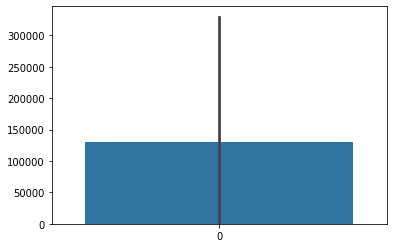

In [ ]:
sns.barplot(data=a)